In [ ]:
import copy
import time
import random
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    MaxPooling2D, AveragePooling2D, GlobalAvgPool2D
)

from tensorflow.keras.datasets import mnist



# LOAD LIBRARIES
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

#전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler

# How to check if Keras is using GPU?

from keras import backend as K

from keras.optimizers import SGD, Adam, Nadam

## 대회 설명

심리테스트를 활용하여 테스트 참가자의 국가 선거 투표 여부 예측

In [ ]:
train = pd.read_csv('./drive/My Drive/ml_data/mental/train.csv', index_col=0)
test = pd.read_csv('./drive/My Drive/ml_data/mental/test_x.csv', index_col=0)
submission = pd.read_csv('./drive/My Drive/ml_data/mental/sample_submission.csv', index_col=0)

In [ ]:
train

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,5.0,539,2.0,586,4.0,1095,5.0,1142,4.0,1287,4.0,883,4.0,851,2.0,851,5.0,816,2.0,579,2.0,924,2.0,366,2.0,876,2.0,633,1.0,1115,30s,2,1,4,Female,1,3,White,Other,2,2,2,1,2,1,7,4,4,3,1,2,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,3.0,2190,1.0,826,1.0,4082,5.0,1867,3.0,1264,5.0,2943,4.0,3927,1.0,4329,5.0,1828,1.0,1214,5.0,2414,5.0,1356,1.0,3039,4.0,4304,1.0,1346,20s,4,2,3,Female,1,1,Asian,Hindu,1,1,0,0,1,2,3,4,0,4,3,2,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,1.0,531,4.0,1167,1.0,1016,3.0,2653,2.0,1569,5.0,998,5.0,2547,2.0,918,4.0,2153,2.0,1304,1.0,1131,5.0,937,4.0,1327,1.0,1170,1.0,1409,30s,3,1,3,Male,1,2,White,Other,2,3,1,5,3,4,2,6,1,3,2,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,2.0,1519,4.0,159,3.0,2275,5.0,2809,4.0,5614,3.0,3219,4.0,1296,4.0,9046,4.0,1216,4.0,1169,4.0,23868,3.0,581,4.0,8830,4.0,2392,5.0,1312,20s,4,2,0,Female,1,1,Asian,Hindu,2,4,1,1,1,3,1,3,1,3,3,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,2.0,628,1.0,991,1.0,1259,5.0,1153,5.0,1388,5.0,740,5.0,1181,4.0,547,2.0,575,1.0,754,4.0,1140,5.0,323,5.0,1070,1.0,583,2.0,1889,20s,3,1,2,Male,1,2,White,Agnostic,1,1,1,6,0,2,0,6,2,6,1,1,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,602,1.0,267,1.0,315,1.0,483,1.0,1016,4.0,278,4.0,611,5.0,215,4.0,388,1.0,299,2.0,1915,4.0,439,2.0,823,1.0,309,5.0,586,4.0,2252,10s,2,1,1,Female,3,1,White,Jewish,1,2,6,1,2,6,3,0,6,4,3,2,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,1680,2.0,560,2.0,640,1.0,1415,2.0,4494,5.0,1392,2.0,2478,5.0,1268,3.0,843,2.0,1401,4.0,1524,4.0,719,2.0,754,3.0,1118,4.0,654,4.0,1197,30s,2,1,2,Male,1,1,White,Atheist,2,2,2,3,1,3,3,4,1,5,1,2,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1
45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,1690,4.0,1253,5.0,1094,1.0,1283,5.0,2209,1.0,1764,5.0,1062,5.0,1489,1.0,1908,4.0,891,1.0,1298,1.0,1200,5.0,473,5.0,1779,3.0,1355,1.0,667,10s,2,1,1,Female,1,1,White,Christian_Other,4,4,2,4,0,1,0,2,1,6,2,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0,1,1


## 변수 설명

Q_A: 질문에 대한 대답  
Q_E: 질문에 답할때 까지 걸린 시간

Qa : Secret  
Qb : 대부분의 범죄자들과 다른 사람들의 가장 큰 차이점은 범인들이 잡힐 만큼 어리석다는 것이다.  
Qc : 다른 사람을 전적으로 신뢰하는 사람은 누구나 말썽을 일으키고 있다.  
Qd : Secret  
Qe : P.T. Barnum은 매 순간 어리버리가 태어난다고 말했을 때 틀렸다.  
Qf : 다른 사람에게 거짓말을 해도 변명의 여지가 없다.  
Qg : Secret  
Qh : 대부분의 사람들은 재산의 손실보다 부모의 죽음을 더 쉽게 잊는다.  
Qi : Secret  
Qj : 모든 사람이 악랄한 기질을 가지고 있으며 기회가 주어지면 나올 것이라고 보는 것이 가장 안전하다.  
Qk : 대체로 중요하고 정직하지 못한 것보다는 겸손하고 정직해지는 것이 낫다.  
Ql : Secret  
Qm : 여기저기서 모퉁이를 돌지 않고는 출세하기 어렵다.  
Qn : Secret  
Qo : 사람들을 다루는 가장 좋은 방법은 그들이 듣고 싶은 말을 하는 것이다.  
Qp : Secret  
Qq : 대부분의 사람들은 기본적으로 착하고 친절하다.  
Qr : 도덕적으로 옳다고 확신할 때만 행동을 취해야 한다.  
Qs : 중요한 사람들에게 아첨하는 것은 현명하다.  
Qt : Secret

age_group : 연령
education : 교육 수준
1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree, 0=무응답

engnat : 모국어가 영어
1=Yes, 2=No, 0=무응답

familysize : 형제자매 수

gender : 성별
Male, Female

hand : 필기하는 손
1=Right, 2=Left, 3=Both, 0=무응답

married : 혼인 상태
1=Never married, 2=Currently married, 3=Previously married, 0=Other

race : 인종
Asian, Arab, Black, Indigenous Australian, Native American, White, Other

religion : 종교
Agnostic, Atheist, Buddhist, Christian_Catholic, Christian_Mormon, Christian_Protestant, Christian_Other, Hindu, Jewish, Muslim, Sikh, Other

urban : 유년기의 거주 구역
1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답

wr_(01~13) : 실존하는 해당 단어의 정의을 앎
1=Yes, 0=No

wf_(01~03) : 허구인 단어의 정의를 앎
1=Yes, 0=No

voted (타겟): 지난 해 국가 선거 투표 여부
1=Yes, 2=No

In [ ]:
train.shape

(45532, 77)

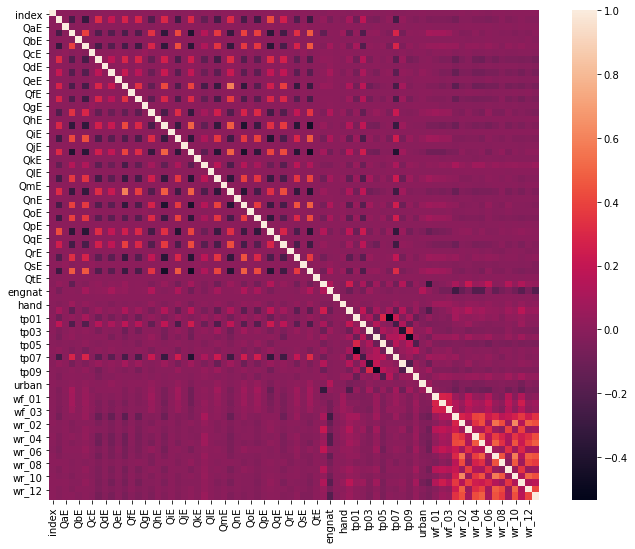

In [ ]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True)

In [ ]:
drop_val = ['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA','QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE','tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']

train = train.drop(drop_val, axis = 1)
test = test.drop(drop_val, axis = 1)
train.head()
test.head()

,age_group,education,engnat,familysize,gender,hand,married,race,religion
index,,,,,,,,,
0,10s,2,2,3,Male,1,1,White,Christian_Protestant
1,10s,2,2,2,Male,2,1,Other,Christian_Catholic
2,30s,3,2,7,Male,1,2,Other,Christian_Other
3,60s,4,1,4,Male,1,2,White,Christian_Catholic
4,10s,2,1,3,Male,1,1,White,Agnostic


In [ ]:
#missing 확인
print('train : ',train.isnull().sum())
print('test : ',test.isnull().sum())

train :  age_group     0
education     0
engnat        0
familysize    0
gender        0
hand          0
married       0
race          0
religion      0
voted         0
dtype: int64
test :  age_group     0
education     0
engnat        0
familysize    0
gender        0
hand          0
married       0
race          0
religion      0
dtype: int64


In [ ]:
#labelencoding
label = LabelEncoder()
train['gender_code'] = label.fit_transform(train['gender'])
train['age_group_code'] = label.fit_transform(train['age_group'])
train['race_code'] = label.fit_transform(train['race'])
train['religion_code'] = label.fit_transform(train['religion'])

test['gender_code'] = label.fit_transform(test['gender'])
test['age_group_code'] = label.fit_transform(test['age_group'])
test['race_code'] = label.fit_transform(test['race'])
test['religion_code'] = label.fit_transform(test['religion'])

drop2 = ['gender','age_group','race','religion']
train = train.drop(drop2, axis = 1)
test = test.drop(drop2, axis = 1)

<BarContainer object of 2 artists>

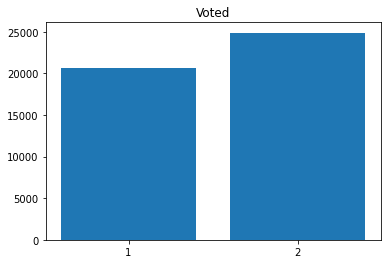

In [ ]:
#target 변수의 분포 파악
train_y = train['voted']

tar = [str(train_y.unique()[1]), str(train_y.unique()[0])]
count= [train_y.value_counts()[1], train_y.value_counts()[2]]
plt.title('Voted')
plt.bar(tar, count)

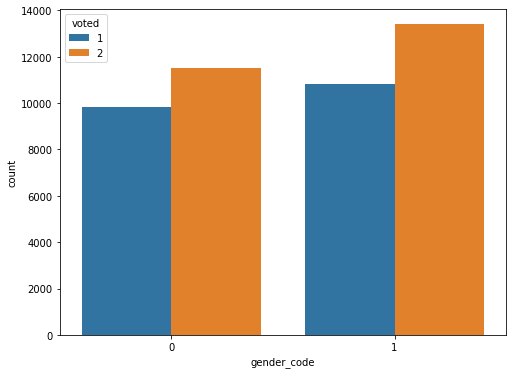

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'gender_code', hue = train_y)

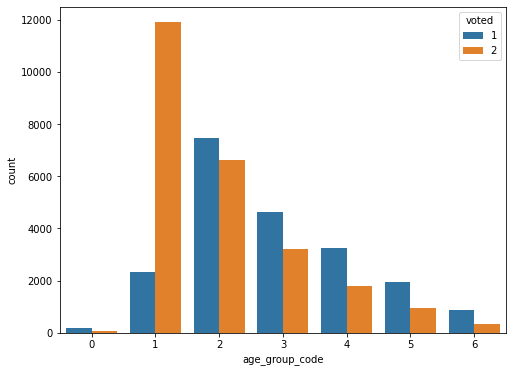

In [ ]:
#굉장이 다른 성향을 보이는 age group이 존재
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'age_group_code', hue = train_y)

In [ ]:
train

,education,engnat,familysize,hand,married,voted,gender_code,age_group_code,race_code,religion_code
index,,,,,,,,,,
0,2,1,4,1,3,2,0,3,6,10
1,4,2,3,1,1,2,0,2,1,7
2,3,1,3,1,2,1,1,3,6,10
3,4,2,0,1,1,1,0,2,1,7
4,3,1,2,1,2,1,1,2,6,0
...,...,...,...,...,...,...,...,...,...,...
45527,2,1,1,3,1,2,0,1,6,8
45528,2,1,2,1,1,2,1,3,6,1
45529,2,1,1,1,1,1,0,1,6,5


In [ ]:
train.columns

Index(['education', 'engnat', 'familysize', 'hand', 'married', 'voted',
       'gender_code', 'age_group_code', 'race_code', 'religion_code'],
      dtype='object')

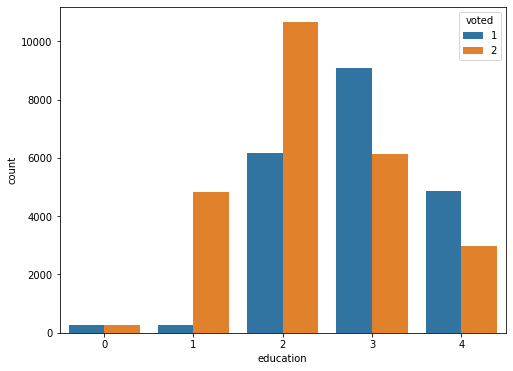

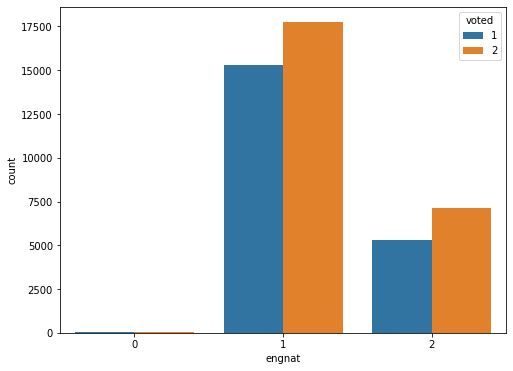

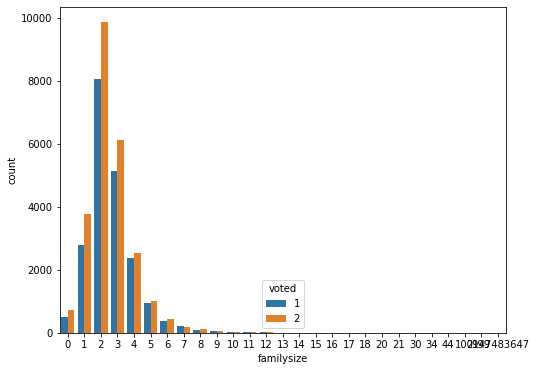

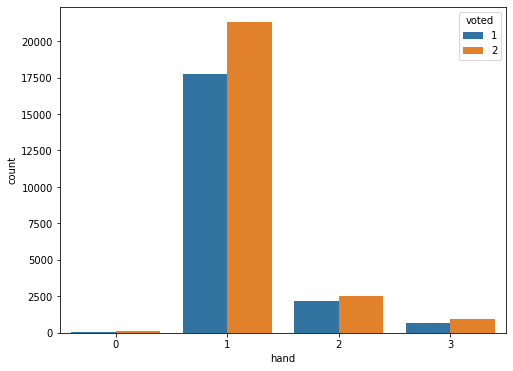

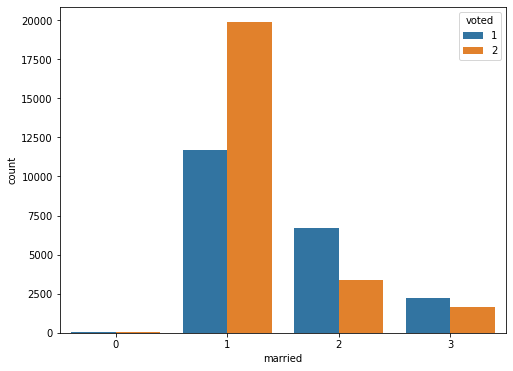

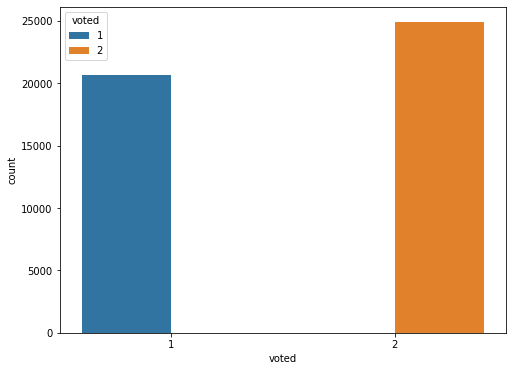

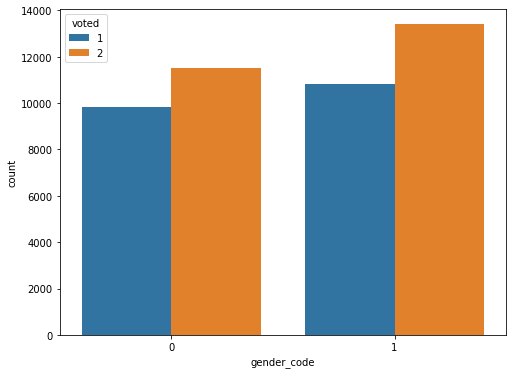

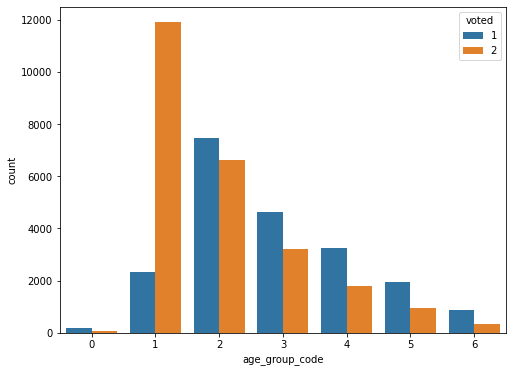

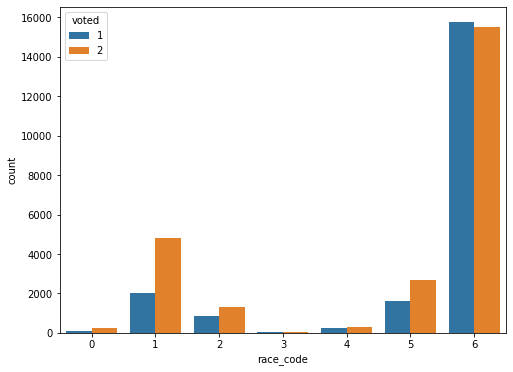

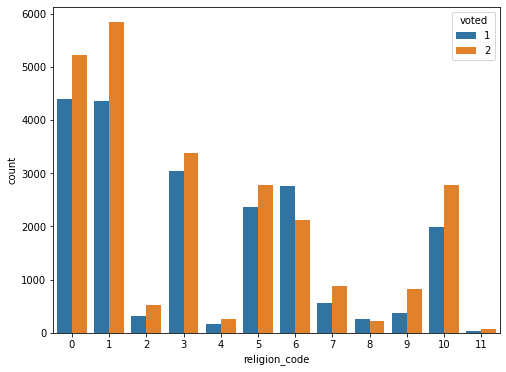

In [ ]:
for col_name in train.columns:
  plt.figure(figsize = (8,6))
  sns.countplot(data = train, x = col_name, hue = train_y)

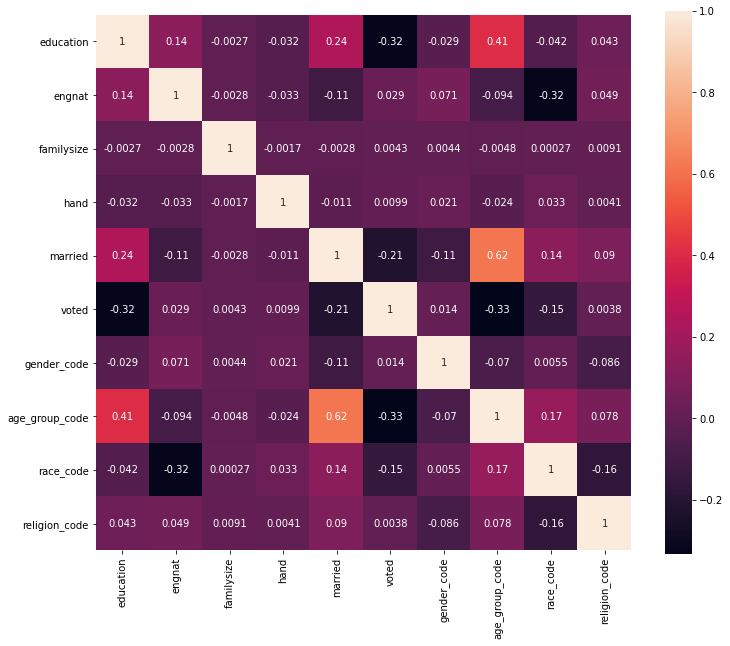

In [ ]:
#heatmap
plt.figure(figsize = (12,10))
sns.heatmap(train.corr(),square = True, annot = True)